In [3]:
import numpy as np
import networkx as nx
import itertools

from scipy import linalg

### The sheaf Laplacian

Matplotlib is building the font cache; this may take a moment.


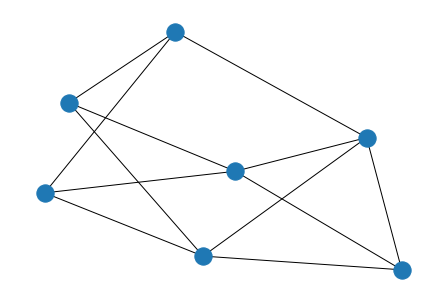

In [4]:
# graph = nx.graph_atlas(13)
graph = nx.graph_atlas(1004)
nx.draw(graph)

In [5]:
B_T = nx.incidence_matrix(graph, oriented=True).toarray().T

E, N = B_T.shape
K = 3  # The dimensionality of the vector spaces. 
one_matrix = np.ones((K, K))
B_T_block = np.kron(B_T, one_matrix)

Delta_base = np.random.uniform(low=-1.0, high=1.0, size=(E * K, N * K))
Delta = B_T_block * Delta_base
L = Delta.T @ Delta

In [6]:
# Check the Sheaf Laplacian has the right shape
assert L.shape == (N*K, N*K)

# Check the matrix is semi-positive definite
assert np.array_equal(L, L.T)
assert np.all(np.linalg.eigvalsh(L) > -1e-13)

In [7]:
I = np.identity(N)
D_ones = np.kron(I, one_matrix)
D = L * D_ones
D_inv = linalg.fractional_matrix_power(D, -0.5)
nL = D_inv @ L @ D_inv

In [8]:
# Check the Sheaf Laplacian has the right shape
assert L.shape == (N*K, N*K)

# Check the matrix is semi-positive definite
assert np.max(np.abs(nL - nL.T)) < 1e-10
assert np.all(np.linalg.eigvalsh(nL) > -1e-13)

# Check the maximum eigenvalue is two
assert np.all(np.linalg.eigvalsh(nL) < (2.0 + 1e-13))

### The Dirichlet Energy

In [9]:
# Define a signal on the zero-th cochain
f = np.random.uniform(low=-1.0, high=1.0, size=(N * K, ))

In [10]:
energy = f.T @ nL @ f
print(energy)

9.254443951036462


In [11]:
def get_edge(i, j):
    for e in range(E):
        if B_T[e, i] * B_T[e, j] != 0:
            return e
    assert not graph.has_edge(i, j)
    assert not graph.has_edge(j, i)
    return None

In [12]:
# Compute energy using the alternative method
energy_alt = 0
for i, j in itertools.combinations(range(N), 2):
    f_i = f[i*K:(i+1)*K]
    f_j = f[j*K:(j+1)*K]
    D_inv_i = D_inv[i*K:(i+1)*K, i*K:(i+1)*K]
    D_inv_j = D_inv[j*K:(j+1)*K, j*K:(j+1)*K]
    
    e = get_edge(i, j) 
    if e is None:
        continue
    F_i = Delta_base[e*K:(e+1)*K, i*K:(i+1)*K]
    F_j = Delta_base[e*K:(e+1)*K, j*K:(j+1)*K]
    
    A = F_i @ D_inv_i
    B = F_j @ D_inv_j
    
    diff = (A @ f_i) - (B @ f_j)
    norm_sq = np.linalg.norm(diff)**2
    energy_alt += norm_sq
print(energy_alt)

9.254443951036459


In [13]:
assert np.abs(energy - energy_alt) < 1e-14